In [1]:
import networkx as nx

import matplotlib.pyplot as plt
import random
import json
import community as community_louvain

import numpy as np

import numpy as np
from scipy.sparse import csr_matrix

import infomap

In [2]:

path  = '/Users/qing/Desktop/24s1/comp8880/project/code/data/yeast/artist_edges.csv'

In [3]:

def read_undirected_graph_csv(file_path, skip_lines):
    G = nx.Graph()  # Initialize an empty undirected graph
    with open(file_path, 'r') as file:
        for _ in range(skip_lines):
            next(file)  # Skip the initial descriptive lines
        for line in file:
            parts = line.strip().split(',')
              # Only consider lines with exactly two node identifiers
            u = parts[0]
            v = parts[1]
            G.add_edge(u, v)
    
    return G


In [9]:
G = read_undirected_graph_csv(path, 0)

G.remove_edges_from(nx.selfloop_edges(G))

In [10]:


def leader_rank(G2, damping=0.85, tol=1e-6, max_iter=100):
    # Add the ground node connected to all other nodes
    ground_node = 'ground'
    G = G2.copy()
    G.add_node(ground_node)
    for node in G2.nodes():  # Connect the ground node to all other nodes
        G.add_edge(ground_node, node)
        G.add_edge(node, ground_node)  # Assuming undirected graph, add both directions

    # Create a mapping from node to index
    node_list = list(G.nodes())
    node_index = {node: i for i, node in enumerate(node_list)}
    n = len(node_list)
    
    # Initialize scores to 1 for all nodes
    scores = np.ones(n)
    
    # Create adjacency matrix
    row = []
    col = []
    data = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            degree = len(neighbors)
            for neighbor in neighbors:
                row.append(node_index[neighbor])
                col.append(node_index[node])
                data.append(1.0 / degree)
    
    adjacency_matrix = csr_matrix((data, (row, col)), shape=(n, n))
    
    # Power iteration: iterate until convergence
    for _ in range(max_iter):
        new_scores = adjacency_matrix.dot(scores)
        if np.linalg.norm(new_scores - scores, 1) < tol:
            break
        scores = new_scores
    
    # Remove the ground node score and normalize the scores
    scores = np.delete(scores, node_index[ground_node])
    total_score = np.sum(scores)
    scores /= total_score
    
    # Create the final scores dictionary
    final_scores = {node_list[i]: scores[i] for i in range(n) if node_list[i] != ground_node}
    
    return final_scores


def calculate_h_index(G):
    h_index = {}
    for node in G.nodes():
        degrees = [G.degree(neighbor) for neighbor in G.neighbors(node)]
        degrees.sort(reverse=True)
        h = 0
        for i, degree in enumerate(degrees):
            if degree >= i + 1:
                h = i + 1
            else:
                break
        h_index[node] = h
    return h_index


In [11]:
degree_centrality = nx.degree_centrality(G)
pagerank = nx.pagerank(G, alpha=0.85, personalization=None)
leaderRank = leader_rank(G)
hIndex = calculate_h_index(G)
kShell = nx.core_number(G)


In [12]:
sorted_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
sorted_pagerank =  sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
sorted_leaderRank =  sorted(leaderRank.items(), key=lambda item: item[1], reverse=True)
sorted_hIndex =  sorted(hIndex.items(), key=lambda item: item[1], reverse=True)
sorted_kShell=  sorted(kShell.items(), key=lambda item: item[1], reverse=True)



In [13]:
# 创建节点映射，将节点字符串映射为整数，同时创建反向映射
node_map = {node: i for i, node in enumerate(G.nodes())}
reverse_node_map = {i: node for node, i in node_map.items()}  # 反向映射

# 初始化 Infomap
im = infomap.Infomap()
#im = infomap.Infomap("--two-level")

# 将网络数据添加到 Infomap 对象，确保节点ID是整数
for edge in G.edges():
    source, target = edge
    im.add_link(node_map[source], node_map[target])

# 运行 Infomap 算法
im.run()


  Infomap v2.7.1 starts at 2024-05-18 18:11:09
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 50515 nodes and 819090 links...
  -> One-level codelength: 14.3944421

Trial 1/1 starting at 2024-05-18 18:11:10
Two-level compression: 11% 1.8% 
Partitioned to codelength 1.94481426 + 10.5820364 = 12.52685063 in 781 modules.
Super-level compression: to codelength 12.52685063 in 781 top modules.

Recursive sub-structure compression: 0.0742243222% 0% 

In [14]:

# 提取社区分区结果，直接使用反向映射
partition_infomap = {}
for node in im.tree:
    if node.is_leaf:
        original_node = reverse_node_map[node.node_id]  # 直接使用反向映射查找原始节点标识符
        partition_infomap[original_node] = node.module_id

In [15]:
def community_aware_ranking_Baseline(G, partition, node_centrality, budget=None):
    # Organize nodes by community and sort them within each community based on their centrality
    community_nodes = {}
    for node, comm in partition.items():
        if comm not in community_nodes:
            community_nodes[comm] = []
        community_nodes[comm].append(node)

    for comm in community_nodes:
        community_nodes[comm].sort(key=lambda x: node_centrality[x], reverse=True)

    # Select nodes from communities ensuring distribution across communities
    ranked_nodes = []
    if budget is None:
        budget = len(G)
    
    while budget > 0 and any(community_nodes.values()):
        for comm in sorted(community_nodes, key=lambda x: len(community_nodes[x]), reverse=True):
            if community_nodes[comm]:
                ranked_nodes.append(community_nodes[comm].pop(0))
                budget -= 1
                if budget == 0:
                    break
    
    return ranked_nodes

In [43]:
import networkx as nx
import numpy as np

def community_aware_ranking_ours_v5(G, partition, incommunity, communityImportance, total_budget, alpha=1.2, beta=1):
    communities = {}
    for node, comm_id in partition.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)

    community_scores = {}
    for comm_id, nodes in communities.items():
        core_score = np.mean([communityImportance[node] for node in nodes])  # 计算该社区的平均k-shell得分
        size_score = len(nodes)  # 获取社区的大小
        community_scores[comm_id] = (size_score ** alpha) * (core_score ** beta)  # 加权计算社区得分

    total_score = sum(community_scores.values())
    community_budgets = {comm: int((score / total_score) * total_budget) for comm, score in community_scores.items()}

    selected_nodes = set()
    for comm_id in communities:
        community_nodes = communities[comm_id]
        budget = community_budgets[comm_id]
        selected_for_comm = []
        nodes_sorted = sorted(community_nodes, key=lambda n: incommunity[n], reverse=True)

        for node in nodes_sorted:
            if len(selected_for_comm) < budget:
               
                selected_for_comm.append(node)
                selected_nodes.add(node)
                    
    return selected_nodes


In [44]:

budget = 100


ranked_nodes_ours = community_aware_ranking_ours_v5(G, partition_infomap,degree_centrality,kShell, budget)
ranked_nodes_baseline = community_aware_ranking_Baseline(G, partition_infomap, degree_centrality, budget)

print("Ranked Nodes:", ranked_nodes_ours)
print("Ranked informap Nodes:", ranked_nodes_baseline)


Ranked Nodes: {'41699', '5140', '38629', '6934', '41998', '1593', '37439', '34423', '13348', '45113', '39284', '39379', '40958', '27821', '23951', '44960', '34597', '18634', '32167', '3875', '3745', '7776', '48099', '21792', '8690', '38391', '21716', '46770', '4324', '43819', '47790', '50299', '4506', '44169', '24957', '37078', '24409', '4030', '46775', '6970', '39019', '39216', '40251', '49209', '31746', '3262', '27969', '28121', '45089', '46851', '12069', '39731', '34975', '41846', '46117', '725', '19158', '7591', '15783', '45196', '40666', '13455', '21245', '22486', '4518', '5338', '16675', '36353', '22766', '37329', '18322', '14666', '7675', '35580', '48794', '37638', '9187'}
Ranked informap Nodes: ['7675', '1593', '34597', '21716', '37078', '46117', '45089', '40666', '38391', '37638', '41846', '50299', '12069', '48794', '39216', '32173', '40251', '4666', '46770', '14666', '5046', '46180', '5140', '27801', '20809', '11586', '21722', '47197', '3066', '20022', '15872', '137', '3089',

In [45]:
def calculate_mu(partition):

    # 初始化社区内和社区外的边数
    intra_community_edges = 0
    inter_community_edges = 0

    # 计算社区内和社区外的边数
    for edge in G.edges():
        if partition[edge[0]] == partition[edge[1]]:
            intra_community_edges += 1
        else:
            inter_community_edges += 1

    # 计算混合参数 μ
    mu = inter_community_edges / (intra_community_edges + inter_community_edges)
    
    return mu

In [46]:
calculate_mu(partition_infomap)

0.36277576334712913

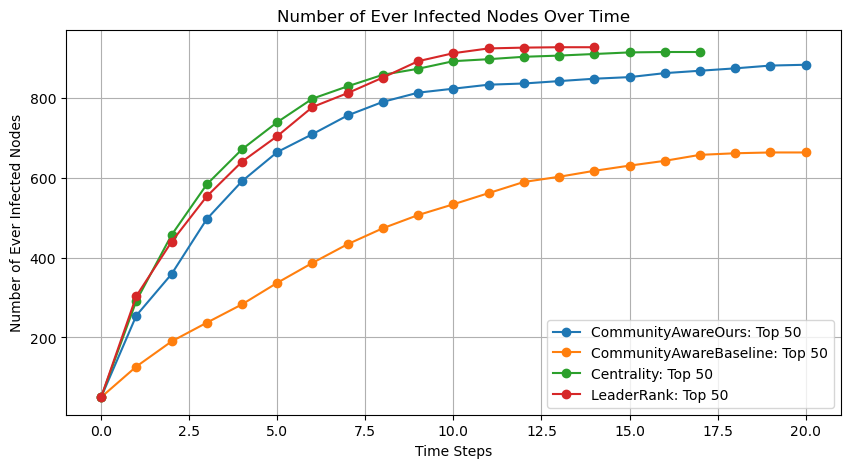

In [57]:

def plot_sir_simulation(G, sorted_maps, top, infection_prob=0.05, steps=100):
    plt.figure(figsize=(10, 5))

    # Calculate average in-degree
    #avg_in_degree = sum(dict(G.in_degree()).values()) / G.number_of_nodes()
   # print(avg_in_degree)
    #recovery_prob = 1 / avg_in_degree

    # Iterate through all sorted maps
    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]  # Extract top nodes
        history, ever_infected, infected_counts = SIR_simulation(G, top_nodes, infection_prob, 0.9, steps)
        plt.plot(infected_counts, marker='o', linestyle='-', label=f'{name}: Top {top}')

    plt.title('Number of Ever Infected Nodes Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Ever Infected Nodes')
    plt.grid(True)
    plt.legend()
    plt.show()

def SIR_simulation(G, initial_infected, infection_prob=0.1, recovery_prob=0.05, steps=100):
    # Initialize the status of each node
    status = {node: 'S' for node in G.nodes()}
    for node in initial_infected:
        status[node] = 'I'

    history = []
    ever_infected = set(initial_infected)
    infected_counts = [len(ever_infected)]  # Initial number of infected nodes

    # Simulation process
    for _ in range(steps):
        new_status = status.copy()
        for node in G.nodes():
            if status[node] == 'I':
                # Determine neighbors based on whether the graph is directed
                if G.is_directed():
                    # For directed graphs, consider nodes that have edges towards 'node'
                    neighbors = [n for n in G.predecessors(node)]
                else:
                    # For undirected graphs, consider all neighbors
                    neighbors = list(G.neighbors(node))

                # Attempt to infect neighbors
                for neighbor in neighbors:
                    if status[neighbor] == 'S' and random.random() < infection_prob:
                        new_status[neighbor] = 'I'
                        ever_infected.add(neighbor)
                # Recovery process
                if random.random() < recovery_prob:
                    new_status[node] = 'R'
        history.append(new_status)
        status = new_status
        infected_counts.append(len(ever_infected))  # Record the total number of infected nodes

        if not any(s == 'I' for s in status.values()):
            break

    return history, ever_infected, infected_counts



sorted_maps = {
    
    "CommunityAwareOurs": [(node, degree_centrality[node]) for node in ranked_nodes_ours],
    "CommunityAwareBaseline": [(node, degree_centrality[node]) for node in ranked_nodes_baseline],
    "Centrality": sorted_centrality,
    #"indegree_centrality": sorted_indegree_centrality,
    #"PageRank": sorted_pagerank,
    "LeaderRank": sorted_leaderRank,
   # "H-index": sorted_hIndex,
    #"K-Shell": sorted_kShell
}


# 运行模拟并绘图
plot_sir_simulation(G, sorted_maps,top=50, infection_prob=0.005,steps=20)

In [39]:


# 统计前top节点在各社区中的分布
def count_top_nodes_in_communities(G, sorted_maps, top, partition):
    community_counts = {name: {} for name in sorted_maps.keys()}
    
    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]  # 提取前top个节点
        for node in top_nodes:
            community = partition[node]
            if community not in community_counts[name]:
                community_counts[name][community] = 0
            community_counts[name][community] += 1
    
    return community_counts

# 可视化前top节点在各社区中的分布
def plot_top_nodes_distribution(community_counts, top):
    plt.figure(figsize=(15, 10))

    for i, (name, counts) in enumerate(community_counts.items()):
        communities = list(counts.keys())
        counts = list(counts.values())
        
        plt.subplot(3, 3, i + 1)
        plt.bar(communities, counts)
        plt.title(f'Distribution of Top {top} Nodes in Communities\n({name})')
        plt.xlabel('Community')
        plt.ylabel('Number of Top Nodes')

    plt.tight_layout()
    plt.show()

# 统计每个社区的节点数量并排序
def count_and_sort_communities(partition):
    community_counts = {}
    for node, community in partition.items():
        if community not in community_counts:
            community_counts[community] = 0
        community_counts[community] += 1
    
    # 按照节点数量排序社区
    sorted_community_counts = sorted(community_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_community_counts

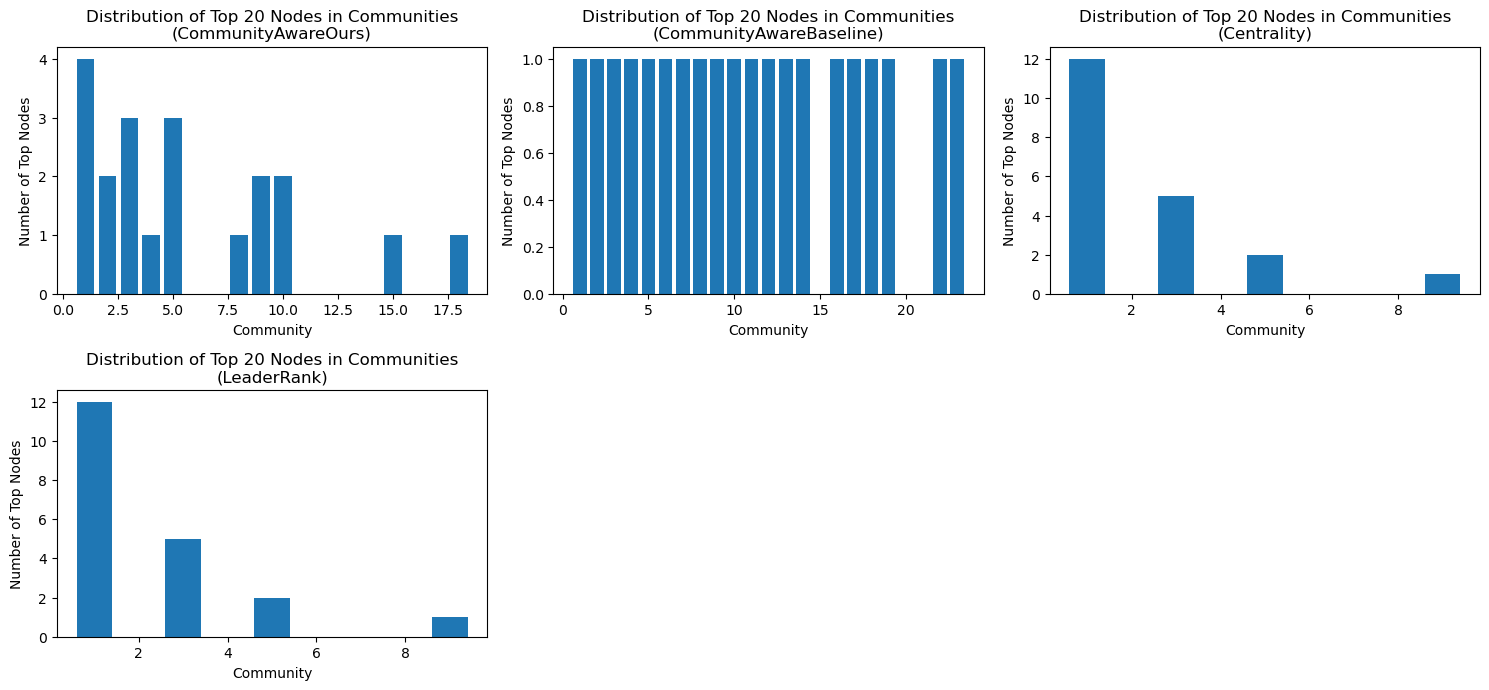

In [40]:

top = 20

community_counts = count_top_nodes_in_communities(G, sorted_maps, top, partition_infomap)
plot_top_nodes_distribution(community_counts, top)

In [42]:

sorted_community_counts = count_and_sort_communities(partition_infomap)

for community, count in sorted_community_counts:
    print(f"Community {community}: {count} nodes")


Community 1: 4413 nodes
Community 4: 3744 nodes
Community 3: 3052 nodes
Community 2: 3041 nodes
Community 5: 2988 nodes
Community 9: 1681 nodes
Community 6: 1592 nodes
Community 7: 1503 nodes
Community 17: 1337 nodes
Community 11: 1285 nodes
Community 18: 1042 nodes
Community 12: 977 nodes
Community 16: 878 nodes
Community 10: 867 nodes
Community 8: 794 nodes
Community 22: 751 nodes
Community 13: 647 nodes
Community 23: 623 nodes
Community 19: 554 nodes
Community 14: 548 nodes
Community 27: 483 nodes
Community 25: 446 nodes
Community 15: 443 nodes
Community 21: 439 nodes
Community 24: 369 nodes
Community 26: 348 nodes
Community 38: 326 nodes
Community 20: 314 nodes
Community 39: 304 nodes
Community 28: 280 nodes
Community 29: 259 nodes
Community 36: 228 nodes
Community 33: 210 nodes
Community 49: 204 nodes
Community 50: 203 nodes
Community 32: 196 nodes
Community 34: 196 nodes
Community 41: 187 nodes
Community 31: 185 nodes
Community 37: 178 nodes
Community 35: 176 nodes
Community 44: 

In [58]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_selected_nodes_with_highlight(G, selected_nodes, top_n=10):
    # 检查 selected_nodes 的数量不小于 top_n
   

    # 选择 top_n 个节点进行突出显示
    # 确保 selected_nodes 列表中只有节点标识符
    top_selected_nodes = [node[0] for node in selected_nodes[:top_n]]

    # 计算布局
    pos = nx.spring_layout(G, seed=42)  # 使用固定的种子以便每次布局相同

    # 手动绘制图形
    plt.figure(figsize=(12, 12))
    # 绘制所有节点
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='#00b4d9')
    # 绘制所有边
    nx.draw_networkx_edges(G, pos)
    # 特别突出显示 top_selected_nodes
    nx.draw_networkx_nodes(G, pos, nodelist=top_selected_nodes, node_color='red', node_size=100)
    # 可选：添加节点的标签
    # nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in top_selected_nodes})

    # 添加标题
    plt.title("Network Visualization with Highlighted Top Nodes")
    # 显示图
    plt.show()

# 使用示例
# 假设 G 是你的图对象，selected_nodes 是已按度中心性排序的节点列表（列表元素为(node, centrality)格式）
# visualize_selected_nodes_with_highlight(G, selected_nodes, top_n=10)


In [59]:
visualize_selected_nodes_with_highlight(G, sorted_centrality, top_n=50)

KeyboardInterrupt: 

In [57]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_selected_nodes_to_Selected(G, selected_nodes, top):
    # 计算网络中节点的数量
    network_size = len(G.nodes())

    # 设置低位数比例为网络大小的 15%
    low_fraction = top
    

    # 确保 selected_nodes 是列表，以便进行索引和切片操作
    selected_nodes = list(selected_nodes)[:low_fraction] if isinstance(selected_nodes, set) else selected_nodes[:low_fraction]

    # 计算布局
    pos = nx.spring_layout(G, seed=42)  # 使用固定的种子以便每次布局相同

    # 手动绘制图形
    plt.figure(figsize=(12, 12))
    # 绘制所有节点
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='#00b4d9')
    # 绘制所有边
    nx.draw_networkx_edges(G, pos)
    # 特别突出显示 top_selected_nodes
    nx.draw_networkx_nodes(G, pos, nodelist=selected_nodes, node_color='red', node_size=100)
    # 添加标签（可选）
    # nx.draw_networkx_labels(G, pos)

    # 添加标题
    plt.title("Network Visualization with Highlighted Top Nodes")
    # 显示图
    plt.show()

# 假设 G 是你的图对象，partition 是社区划分，selected_nodes 是选出的节点列表（已排序）
# visualize_selected_nodes_with_highlight(G, partition, selected_nodes)


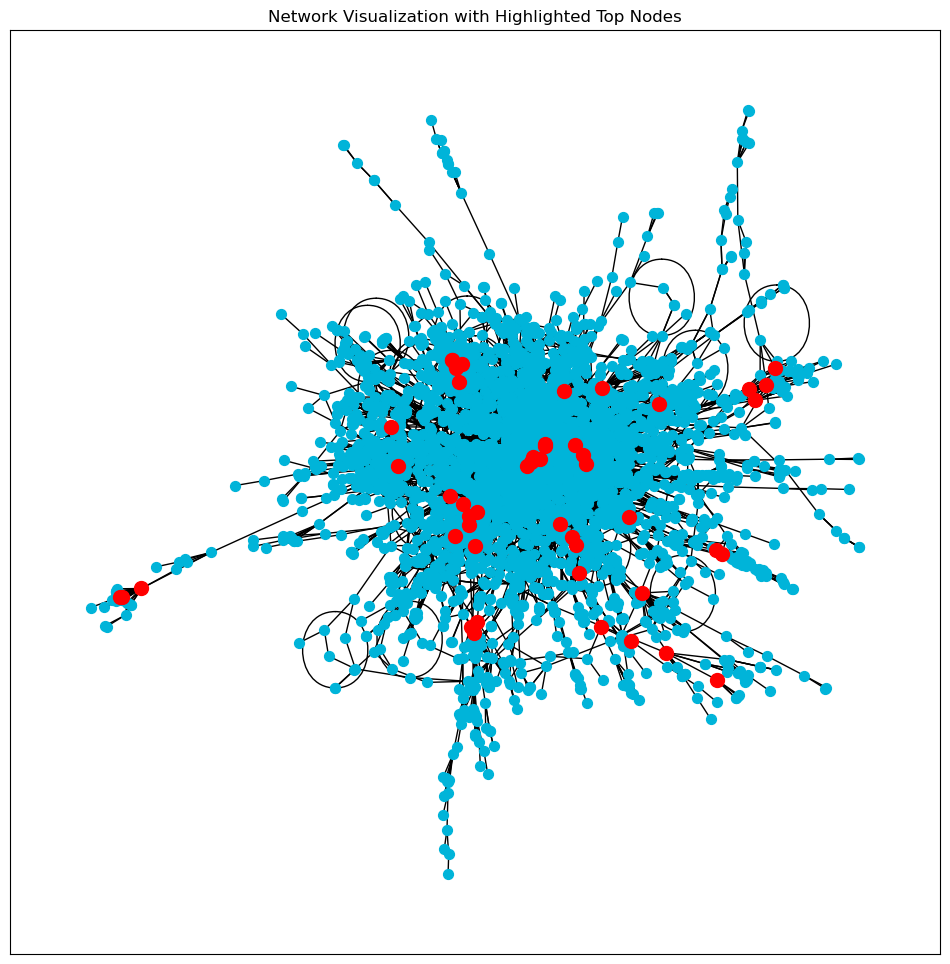

In [58]:
visualize_selected_nodes_to_Selected(G, ranked_nodes_ours,50)